### Analysis of data to explore marketing outcome
The objective of this analysis is to optimise the marketing efforts by determining the likelihood of customers purchasing term deposits based on the previous data, there by increasing the hit ratio. 

We will import all the packages required for this analysis, at the outset.

In [117]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB


bank_df = pd.read_csv("bank-full.csv");
bank_df.head()




,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [118]:
bank_df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

As we can see, there are many non-numerical columns in the dataset. Let's ascertain the unique values in these columns inorder to understand the data.

In [119]:
for col in ['job', 'marital', 'education', 'default','housing',
            'loan','contact','day','month','poutcome','Target']:
    print(f'Unique values in column {col} are : {bank_df[col].unique()}\n')
    

Unique values in column job are : ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

Unique values in column marital are : ['married' 'single' 'divorced']

Unique values in column education are : ['tertiary' 'secondary' 'unknown' 'primary']

Unique values in column default are : ['no' 'yes']

Unique values in column housing are : ['yes' 'no']

Unique values in column loan are : ['no' 'yes']

Unique values in column contact are : ['unknown' 'cellular' 'telephone']

Unique values in column day are : [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]

Unique values in column month are : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

Unique values in column poutcome are : ['unknown' 'failure' 'other' 'success']

Unique values in column Target are : ['no' 'yes']



While some of the column headings are evident, some are abstract. Let's explore what each of the column means in detail. 

## Description of the bank client data:

### Data related to the customer
**age** (numeric) Age of the customer in years.

**job** : type of job the customer is in
    (categorical: 'management', 'technician', 'entrepreneur', 'blue-collar', 'unknown',
 'retired', 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid',
 'student'

**marital** : marital status (categorical: married, single, divorced) (Widowed is not specified. We will presume it comes under single.)

**education** (categorical: primary, secondary, tertiary, unknown)

**balance** Average balance maintained in the account

**default** : Whether the customer has defaulted credit/loan previously? (categorical: yes,no)

**housing**: Whether the customer has housing loan? (categorical: yes,no)

**loan**: Whether the customer has personal loan? (categorical: yes,no)

### Data related to current campaign
**contact** : contact communication type (categorical: 'cellular','telephone','unknown')

**day** : Day of the month of last contact 

**month** : last contact month of year (categorical: jan to dec)

**duration** : last contact duration, in seconds (numeric). 

**campaign** : number of contacts performed during this campaign and for this customer

### Data related to previous campaign
**pdays** : number of days that passed by after the customer was last contacted from a previous campaign. -1 means the client was not contacted before. 

**previous**: number of contacts performed before this campaign and for this customer

**poutcome**: Outcome of the previous marketing campaign (categorical: success, failure, unknown, other)

**target** Whether the customer could be successfully marketed to or not. In other words, whether or not the customer availed term deposit.



In [120]:
print(f"Maximum days lapsed since contact for previous campaign ", bank_df.pdays.max())
print(f"Minimum days lapsed since contact for previous campaign ", bank_df.pdays.min())

"""
Ascertaining the number of customers where the previous outcome 
is unknown though a previous contact was made
"""
print("Number of customers where previous outcome is 'unknown' though contact was made is ",bank_df['previous'][bank_df['poutcome'] == "unknown"][bank_df['previous'] != 0].count())


"""
Ascertaining the number of customers where the previous outcome 
is others though a previous contact was made
"""
print("Number of customers where previous outcome is 'other' though contact was made is ",bank_df['previous'][bank_df['poutcome'] == "other"][bank_df['previous'] != 0].count())

Maximum days lapsed since contact for previous campaign  871
Minimum days lapsed since contact for previous campaign  -1
Number of customers where previous outcome is 'unknown' though contact was made is  5
Number of customers where previous outcome is 'other' though contact was made is  1840


In [121]:
bank_df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

In [122]:
bank_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


Number of positive cases: 5289 
Number of negative cases: 39922


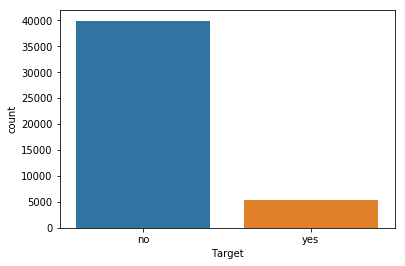

In [123]:
positive = len(bank_df.loc[bank_df['Target'] == 'yes'])
negative = len(bank_df.loc[bank_df['Target'] == 'no'])
print("Number of positive cases: {0} ".format(positive))
print("Number of negative cases: {0}".format(negative))

sns.countplot(bank_df['Target'])

From the graph and the values printed above, it is evidently clear that the data set is highly imbalanced. 

Before balancing the dataset, let's keep the dataset as is and explore it. The dataset has many values which are actually categorical. We will convert these in categorical type and then let's perform Chi square test between each of the categorical values and the outcome. The null hypothesis will be that the two are completely independent and there is no correlation between the two. But if the p value is less than .05, we have to reject the null hypothesis and infer that there is a correlation between the variables. We will create a copy of the original dataset to do all transformation and analysis.


Null hyopthesis rejected. The p value is  3.337121944935502e-172 . 
There is correlation between  Employment  and outcome


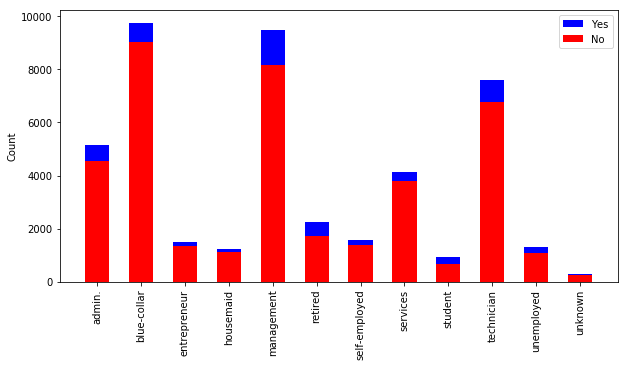

Null hyopthesis rejected. The p value is  2.1450999986791486e-43 . 
There is correlation between  MaritalStatus  and outcome


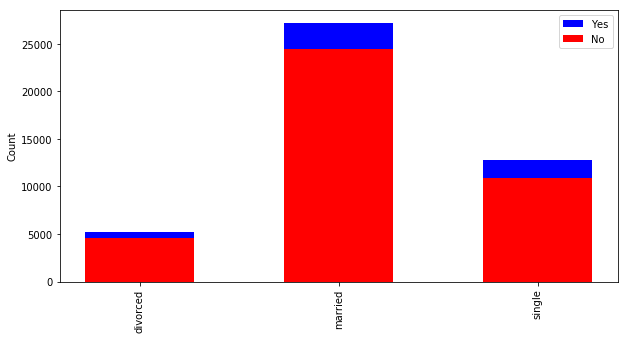

Null hyopthesis rejected. The p value is  1.6266562124072994e-51 . 
There is correlation between  Education  and outcome


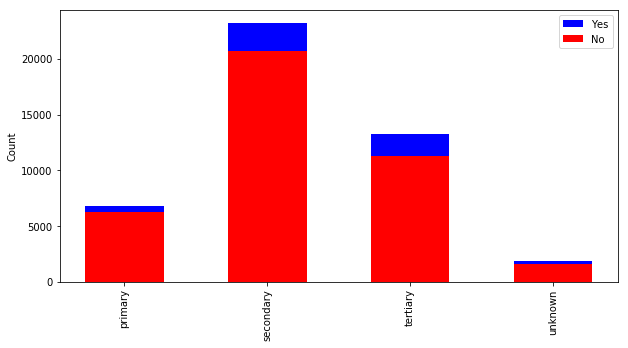

Null hyopthesis rejected. The p value is  2.4538606753508344e-06 . 
There is correlation between  Defaulter  and outcome


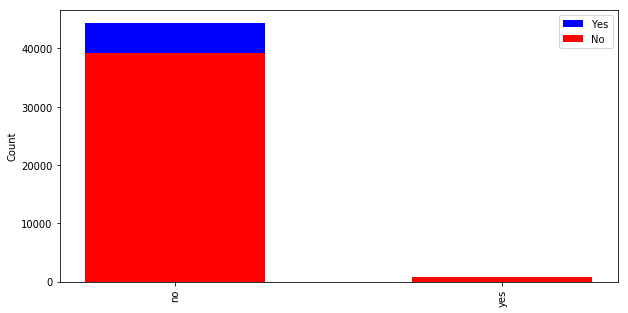

Null hyopthesis rejected. The p value is  2.918797605076633e-192 . 
There is correlation between  HousingLoan  and outcome


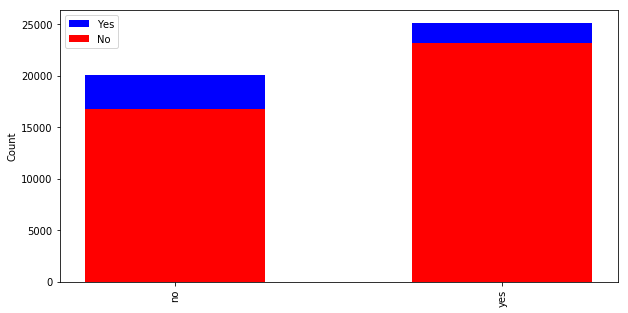

Null hyopthesis rejected. The p value is  1.665061163492756e-47 . 
There is correlation between  PersonalLoan  and outcome


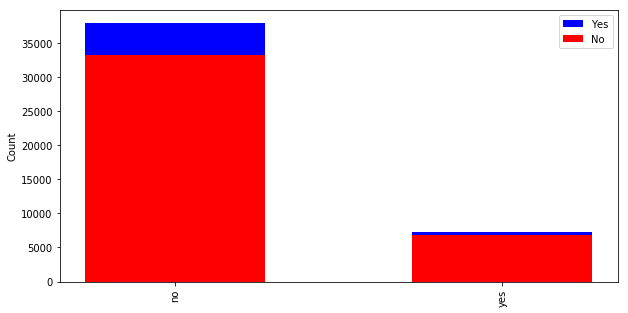

Null hyopthesis rejected. The p value is  1.251738325340495e-225 . 
There is correlation between  Contact  and outcome


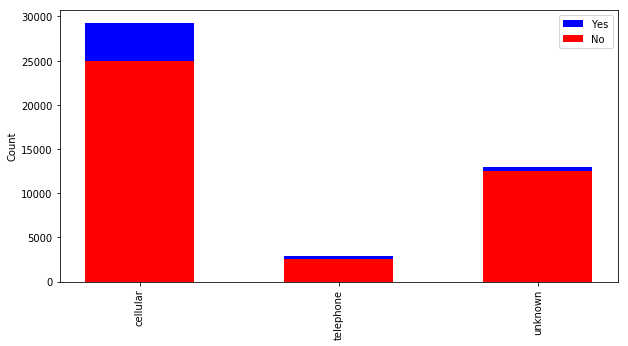

Null hyopthesis rejected. The p value is  0.0 . 
There is correlation between  LastContact_Month  and outcome


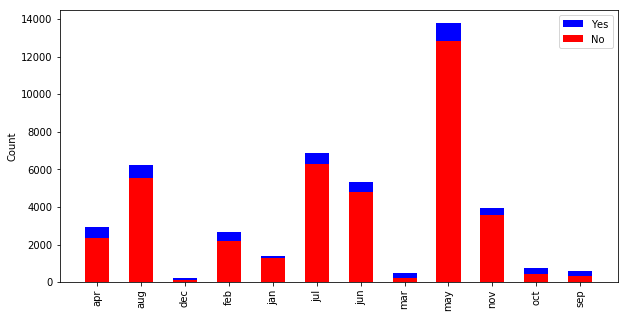

Null hyopthesis rejected. The p value is  0.0 . 
There is correlation between  PreviousOutcome  and outcome


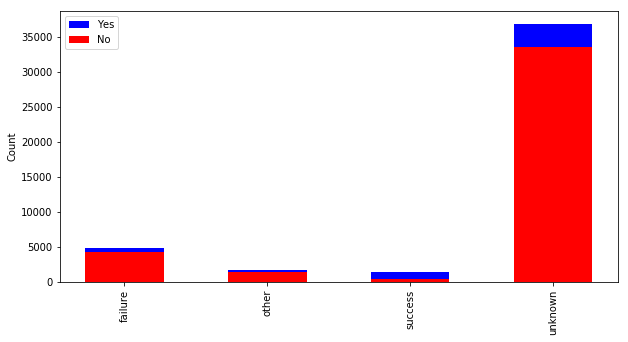

In [124]:
bank_df_workingcopy = bank_df.copy()

bank_df_workingcopy.columns = ["Age","Employment","MaritalStatus","Education","Defaulter","Balance",
                   "HousingLoan","PersonalLoan","Contact","LastContact_DayOfMonth",
                   "LastContact_Month","DurationOfCall","No.OfContactsMade",
                   "DaysSincePrevContact","TimesPreviouslyContacted","PreviousOutcome","Outcome"]


for col in ['Employment','MaritalStatus','Education','Defaulter','HousingLoan',
            'PersonalLoan','Contact','LastContact_Month','PreviousOutcome','Outcome']:
    bank_df_workingcopy[col] = bank_df_workingcopy[col].astype('category')    
    if(col == "Outcome"):
        continue
    compare_table = pd.crosstab(bank_df_workingcopy['Outcome'],bank_df_workingcopy[col]);
    chi2,p,dof,expected = chi2_contingency(compare_table.values)
    if(p<0.5) :
        print("Null hyopthesis rejected. The p value is ",p,". \nThere is correlation between ",col," and outcome");
    else :
        print("Null hyopthesis accepted. The p value is ",p,". \nThere is no correlation between ",col," outcome");
    no_count = compare_table.iloc[0][:].values
    yes_count = compare_table.iloc[1][:].values

    #Plots the bar chart
    fig = plt.figure(figsize=(10, 5))
    categories = sorted(bank_df_workingcopy[col].unique())
    p1 = plt.bar(categories, no_count, 0.55, color='red', animated=True)
    p2 = plt.bar(categories, yes_count, 0.55, color = 'blue', bottom=no_count,animated=True)
    plt.legend((p2[0], p1[0]), ('Yes', 'No'))
    plt.ylabel('Count')
    plt.xticks(rotation='vertical')
    plt.show()

Based on the Chi square tests we can infer that most of the outcome is certainly dependent on the categorical variables Employment, MaritalStatus, Education, Defaulter, HousingLoan, PersonalLoan, Contact, LastContact_Month and PreviousOutcome. But since the target column values are highly imbalanced, using this dataset will not clearly indicate the possible outcome.

From the description of the dataset done above, it is evident that while some of the features which are continuously distributed are normal, some are not. The difference between their mean and median is too varied. Let's take a subset of the dataframe with just the continous features and pairplot them and observe the same. 


/Users/lavanyas/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


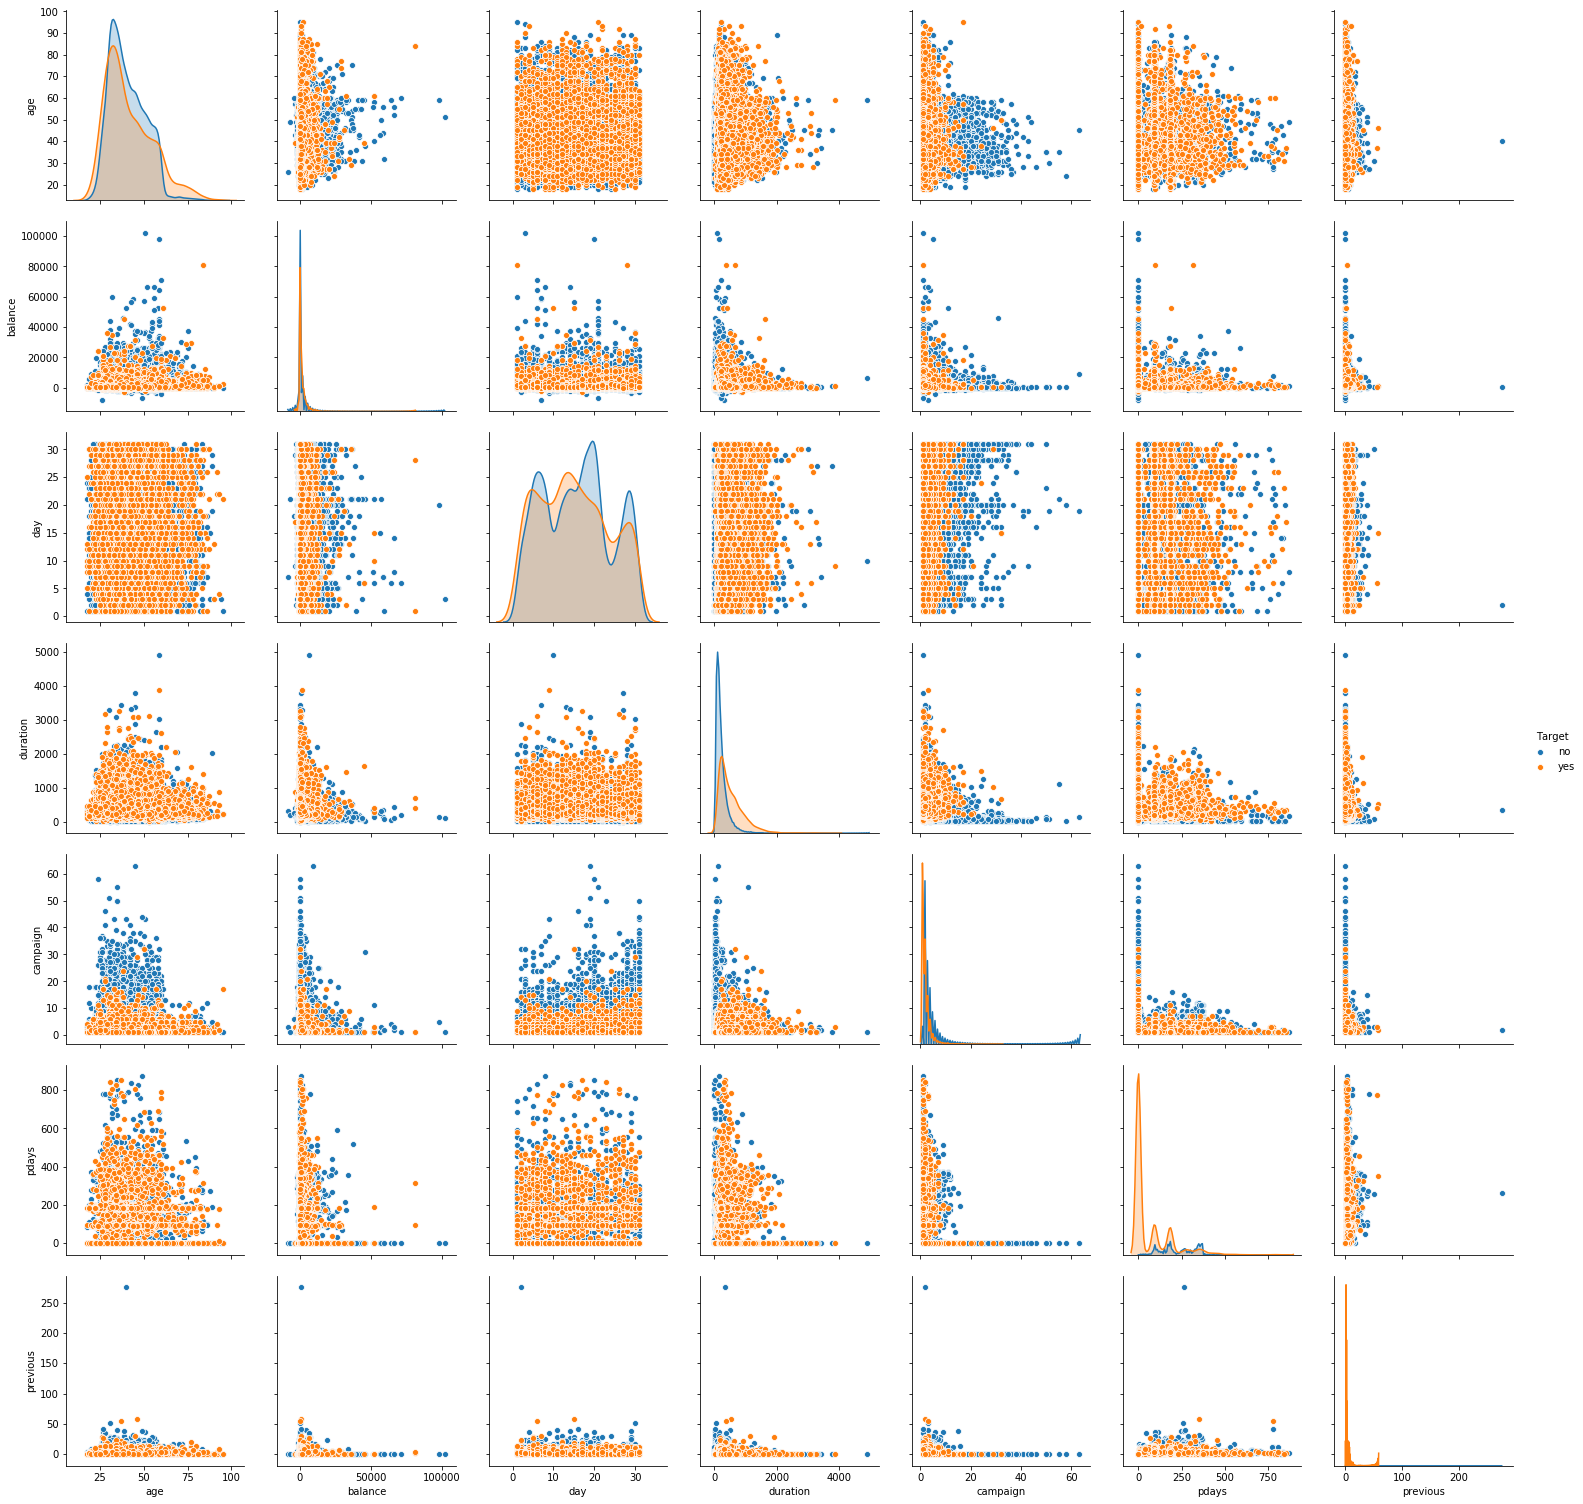

In [125]:
bank_df_transformed = bank_df.copy()

sns.pairplot(bank_df_transformed,hue="Target",height=3)

Let's heatmap the correlation between the features to understand it better.

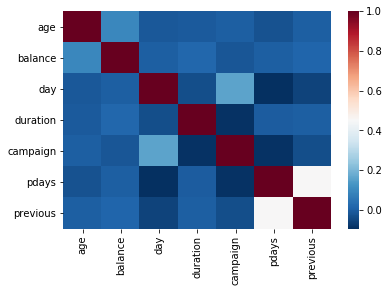

In [126]:
sns.heatmap(bank_df_transformed.corr(),cmap="RdBu_r")


From the heat plot, it appears like besides the duration of the call and previous contact made with the customer, no other feature which is continuous seems to influence the outcome much. It is obvious that any customer who has taken term deposit has been spoken to, but the vice versa is not true. We cannot conclude on the dependence or lack of it, especially given that the number of positive outcomes in the data set is way lesser than the number of negative outcome. Our objective is to find the likelihood of the customer who will be likely to avail term deposit given these features. Let's do supervised classification to ascertain the same. 

To ensure that we consider all the features, let's convert all the values to numeric type and then scale it to explore further. 

In [127]:
bank_df_workingcopy.dtypes

Age                            int64
Employment                  category
MaritalStatus               category
Education                   category
Defaulter                   category
Balance                        int64
HousingLoan                 category
PersonalLoan                category
Contact                     category
LastContact_DayOfMonth         int64
LastContact_Month           category
DurationOfCall                 int64
No.OfContactsMade              int64
DaysSincePrevContact           int64
TimesPreviouslyContacted       int64
PreviousOutcome             category
Outcome                     category
dtype: object

In [128]:
bank_df_workingcopy['Education'].replace(['unknown','primary', 'secondary', 'tertiary'],[1,2,3,4],inplace = True);


bank_df_workingcopy['Employment'].replace(['unknown', 'unemployed', 'retired',
                                     'student', 'housemaid','services',
                                    'admin.','technician','blue-collar',
                                     'self-employed','management','entrepreneur'],
                       [0,1,2,3,4,5,6,7,8,9,10,11],inplace = True);

bank_df_workingcopy['MaritalStatus'].replace(['single' ,'married' ,'divorced'],[0,1,2],inplace = True);

bank_df_workingcopy['Defaulter'].replace(['no','yes'],[0,1],inplace = True);
bank_df_workingcopy['HousingLoan'].replace(['no','yes'],[0,1],inplace = True);
bank_df_workingcopy['PersonalLoan'].replace(['no','yes'],[0,1],inplace = True);
bank_df_workingcopy['Contact'].replace(['unknown','cellular', 'telephone'],[0,1,2],inplace = True);
bank_df_workingcopy['LastContact_Month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],[1,2,3,4,5,6,7,8,9,10,11,12],inplace = True);
bank_df_workingcopy['PreviousOutcome'].replace(['unknown', 'failure' ,'other', 'success'],[-1,0,2,1],inplace = True);
bank_df_workingcopy['Outcome'].replace(['no','yes'],[0,1],inplace = True);

bank_df_workingcopy.dtypes


Age                         int64
Employment                  int64
MaritalStatus               int64
Education                   int64
Defaulter                   int64
Balance                     int64
HousingLoan                 int64
PersonalLoan                int64
Contact                     int64
LastContact_DayOfMonth      int64
LastContact_Month           int64
DurationOfCall              int64
No.OfContactsMade           int64
DaysSincePrevContact        int64
TimesPreviouslyContacted    int64
PreviousOutcome             int64
Outcome                     int64
dtype: object

In [129]:
TD_outcome = bank_df_workingcopy['Outcome']
bank_df_workingcopy = bank_df_workingcopy.drop(labels='Outcome', axis = 1)

X = np.array(bank_df_workingcopy)
y = np.array(TD_outcome)

X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.30, random_state=1)

clf = GaussianNB()
clf.fit(X_train,y_train)


clf.score(X_test, y_test)
test_prediction = clf.predict(X_test)
print("Model Accuracy with test data : ",metrics.accuracy_score(y_test, test_prediction))

print("Confusion Matrix")

confusion_matrix = metrics.confusion_matrix(y_test, test_prediction, labels=[1, 0])

print(confusion_matrix)




Model Accuracy with test data :  0.8468740784429372
Confusion Matrix
[[  809   742]
 [ 1335 10678]]


The above analysis is based on data which is not normalized. Let's do some scaling and run the test again.

In [130]:
X_scaled = preprocessing.scale(X_train)

X_test_scaled = preprocessing.scale(X_test)

clf.fit(X_scaled,y_train)
clf.score(X_test_scaled, y_test)
scaled_test_prediction = clf.predict(X_test_scaled)
print("Model Accuracy with test data : ",metrics.accuracy_score(y_test, scaled_test_prediction))

print("Confusion Matrix")

confusion_matrix = metrics.confusion_matrix(y_test, scaled_test_prediction, labels=[1, 0])

print(confusion_matrix)


Model Accuracy with test data :  0.8473901503981126
Confusion Matrix
[[  831   720]
 [ 1350 10663]]


/Users/lavanyas/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/lavanyas/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


The accuracy still seems to be of the same range and from the outcome we see that having an imbalanced data is not going to help us come to devise an optimal marketing plan based on predicted outcome. The issue with imbalanced data is biased predictions and misleading accuracy. Moving forward we will do our analysis using ensembling techniques. Let's first import all the modules required for this purpose and then use SMOTE (Synthetic Minority Over
Sampling Technique) available in imblearn module, to do our classification.

In [131]:
#pip install imblearn as this doesn't come with the default anaconda
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


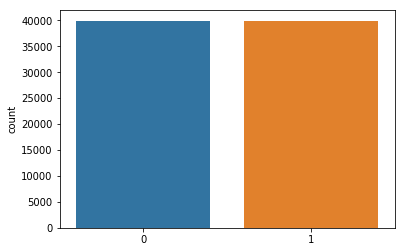

In [132]:
sm = SMOTE(random_state=5)
X_res, y_res = sm.fit_resample(X, y)
sns.countplot(y_res)


We can see from the plot above that the dataset is now balanced with the help of the data sythesised. 

### Classification using DecisionTreeClassifier

In [133]:
X_res_train, X_res_test,y_res_train,y_res_test = train_test_split(X_res,y_res, test_size = 0.30, random_state=1)

dt_model = DecisionTreeClassifier(criterion = 'entropy' );

dtree = dt_model.fit(X_res_train, y_res_train);

y_res_predict = dt_model.predict(X_res_test);

print("Confusion Matrix")

confusion_matrix = metrics.confusion_matrix(y_res_test, y_res_predict, labels=[1, 0])

print(confusion_matrix)

print("The performance score on test data is ",dt_model.score(X_test , y_test))
print("The performance score on training data is ",dt_model.score(X_train , y_train))



Confusion Matrix
[[10852  1077]
 [ 1481 10544]]
The performance score on test data is  0.9446328516661752
The performance score on training data is  0.9640724239264385


The accuracy of the outcome prediction on test data is 94%. But this could be a biassed result. Let's set some regularization parameters on the classifier and analyze the results.

### Classification using generalized DecisionTreeClassifier

In [134]:
dt_model_gen = DecisionTreeClassifier(criterion = 'entropy' ,max_depth=5)

dt_model_gen.fit(X_res_train, y_res_train);

y_res_predict = dt_model_gen.predict(X_res_test);

print("Confusion Matrix")

confusion_matrix = metrics.confusion_matrix(y_res_test, y_res_predict, labels=[1, 0])

print(confusion_matrix)

print("The performance score on test data is ",dt_model_gen.score(X_res_test , y_res_test))
print("The performance score on training data is ",dt_model_gen.score(X_res_train , y_res_train))


Confusion Matrix
[[10624  1305]
 [ 2577  9448]]
The performance score on test data is  0.8379393838189864
The performance score on training data is  0.8420647700840937


We can see that after regularization, the DecisionTreeClassifier's performance score has drastically dropped by more than 10%. We will apply some ensemble techniques and do the classification to minimize bias and variance. 

## Ensemble Techniques

### Classification using GradientBoostingClassifier

In [135]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.05)
gbcl = gbcl.fit(X_res_train, y_res_train)

y_res_predict = gbcl.predict(X_res_test);

print("Confusion Matrix")

confusion_matrix = metrics.confusion_matrix(y_res_test, y_res_predict, labels=[1, 0])

print(confusion_matrix)

print("The performance score on test data is ",gbcl.score(X_res_test , y_res_test))
print("The performance score on training data is ",gbcl.score(X_res_train , y_res_train))



Confusion Matrix
[[10570  1359]
 [ 2181  9844]]
The performance score on test data is  0.8522167487684729
The performance score on training data is  0.8575415995705851


### Classification using RandomForestClassifier

In [136]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_res_train, y_res_train)

y_res_predict = rfcl.predict(X_res_test);

print("Confusion Matrix")

confusion_matrix = metrics.confusion_matrix(y_res_test, y_res_predict, labels=[1, 0])

print(confusion_matrix)

print("The performance score on test data is ",rfcl.score(X_res_test , y_res_test))
print("The performance score on training data is ",rfcl.score(X_res_train , y_res_train))



Confusion Matrix
[[11305   624]
 [ 1175 10850]]
The performance score on test data is  0.9248977206312098
The performance score on training data is  0.9998747539810342


### Classification using Bagging Classifier

In [137]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=20, max_samples= .7, bootstrap=True)
bgcl = bgcl.fit(X_res_train, y_res_train)

y_res_predict = bgcl.predict(X_res_test);

print("Confusion Matrix")

confusion_matrix = metrics.confusion_matrix(y_res_test, y_res_predict, labels=[1, 0])

print(confusion_matrix)

print("The performance score on test data is ",bgcl.score(X_res_test , y_res_test))
print("The performance score on training data is ",bgcl.score(X_res_train , y_res_train))



Confusion Matrix
[[11227   702]
 [ 1227 10798]]
The performance score on test data is  0.9194706520831594
The performance score on training data is  0.9910717480765789


### Classification using KNN as base estimator for Bagging

In [138]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(5)
bgcl = BaggingClassifier(base_estimator=knn_clf, n_estimators=20)
bgcl = bgcl.fit(X_res_train, y_res_train)

y_res_predict = bgcl.predict(X_res_test);

print("Confusion Matrix")

confusion_matrix = metrics.confusion_matrix(y_res_test, y_res_predict, labels=[1, 0])

print(confusion_matrix)

print("The performance score on test data is ",bgcl.score(X_res_test , y_res_test))
print("The performance score on training data is ",bgcl.score(X_res_train , y_res_train))


Confusion Matrix
[[11359   570]
 [ 2678  9347]]
The performance score on test data is  0.864406779661017
The performance score on training data is  0.9088208981928789


## Conclusion
Of all the ensemble classification methods used to explore the dataset after balancing, RandomForestClassifier has the highest accuracy with testing data and training data and this model's prediction can be used for marketing the term deposits by the bank.